In [1]:
import numpy as np
import scipy.signal as signal
import random
import cvxpy as cp
from helper import awgn, draw, draw_3d, hermitian, RMSE, findNMaxPeaks
import time
import matplotlib.pyplot as plt
import sys
epsilon = 1e-11

In [2]:
N = 0
M = 0
f = []
a = lambda f : np.array([ np.exp(-1j* i * 2 * np.pi * f ) for i in range(M) ], dtype=complex).reshape((M,1))

# signal model
def create_signal(snr, numSample, numArrElem, numFreq=None, freqs=None):
  global N,M,f,a
  N = numSample # number of samples
  M = numArrElem # number of arr elem
  f = []
  if (type(freqs) != type(None)):
    f = freqs
  else:
    intervals = np.linspace(0,1,numFreq+1)
    width = intervals[1]
    for k in range(len(intervals)):
      if (k==0):
        continue
      f.append(random.random() * (width) + (intervals[k-1]))
    f.sort()
  A = np.hstack([ a(ff) for ff in f ])
  s = lambda f : 2 * np.exp( 1j * f * np.array(range(N)).reshape((N,1)) )
  S = np.hstack([ s(ff) for ff in f ]).T
  X = A @ S
  # X = np.array([awgn(X[i], snr) for i  n range(M)])
  X = awgn(X, snr)
  return X
X = create_signal(100, numSample=500, numArrElem=25, numFreq=5)
print(X.shape)
# plt.xticks(np.array(range(M))+1)
# plt.xlabel("array element m")
# plt.ylabel("singal amplitude")
# plt.plot(list(range(M)), np.real(X[:,0]), label = "real")
# plt.plot(list(range(M)), np.imag(X[:,0]), label = "imag")
# plt.legend()
# plt.show()
# # draw(list(range(N)), np.real(X[0,:]), "time t", "real part of singal received by {}'th element".format(0+1), "Singal")
# # draw(list(range(N)), np.imag(X[0,:]), "time t", "imag part of singal received by {}'th element".format(0+1), "Singal")
# draw_3d(list(range(M)), np.real(X[:,0]), np.imag(X[:,0]), "t", "real part", "imag part")

(25, 500)


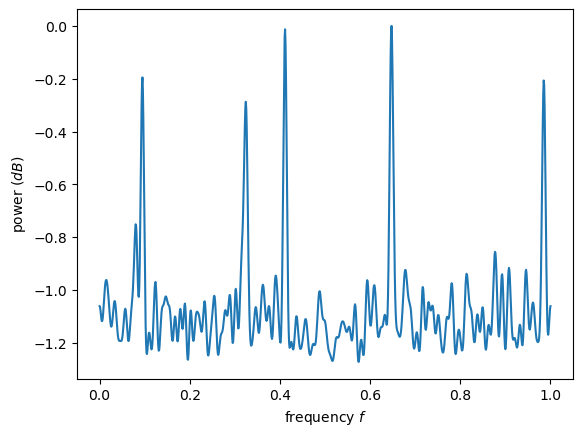

In [3]:
def MUSIC(X, numFreq, numSampling):
  Rxx = X @ hermitian(X)
  eigVal, eigVec = np.linalg.eigh(Rxx)
  NN = eigVec[:, 0:M-numFreq]
  Pmusic = []
  f_list = np.linspace(0,1,numSampling)
  for fx in f_list:
    Pmusic.append(1.0 / np.linalg.norm(hermitian(NN) @ a(fx))**2)
  pMax = np.max(Pmusic)
  Pmusic = np.real(10*np.log10(Pmusic/pMax))
  # Pmusic = np.real(Pmusic/pMax)
  return Pmusic

xx = np.linspace(0,1,1000)
X = create_signal(100, numSample=1, numArrElem=100, numFreq=5)
y = MUSIC(X,len(f), 1000)
draw(xx,y,"frequency $f$","power $(dB)$","")


In [4]:
peaks, props = signal.find_peaks(y)
print(f)
print(np.sort(xx[peaks[findNMaxPeaks(y,peaks,len(f))]]))
print(RMSE(np.sort(xx[peaks[findNMaxPeaks(y,peaks,len(f))]]),f))

[0.09465385461667863, 0.32432490481862997, 0.4112567321612291, 0.6468964488883266, 0.9855776390274656]
[0.0950951  0.32432432 0.41141141 0.64764765 0.98498498]
0.00047626831876113214


[[10.00007091+3.29751247e-05j]
 [-0.15602466-2.18892575e+00j]
 [ 1.85893105-1.66702790e-02j]
 [ 5.54051153-2.34106566e+00j]
 [-3.09186899+4.15971175e-02j]
 [ 0.45337756-7.58079343e-01j]
 [ 1.28795408+3.48008106e+00j]
 [-0.20827335+2.64070130e+00j]
 [ 0.33902352+7.24166573e-01j]
 [ 4.58427219+7.74111519e+00j]
 [ 2.76469365-1.45164482e+00j]
 [ 0.71233898+9.58998881e-01j]
 [ 5.79635023+4.30694336e+00j]
 [-1.39312344-4.81237688e+00j]
 [-0.27951865+1.93429843e+00j]
 [ 0.3893241 +2.66054585e+00j]
 [-3.93595036-3.39735483e-01j]
 [ 0.51639652+3.57818850e+00j]
 [-2.51624849+6.04043637e+00j]
 [ 1.61832153+2.08944403e+00j]
 [ 1.25519148+1.80200694e+00j]
 [-0.94436362+6.42823733e+00j]
 [ 4.37874974-3.24395972e+00j]
 [-2.52043486+3.15892386e-01j]
 [-1.58993622+3.39551333e+00j]
 [-0.51499982-4.93717852e+00j]
 [-5.03813088+3.79057089e+00j]
 [-3.69669288+2.32731417e+00j]
 [-1.54731109+6.67033434e-01j]
 [-1.5466286 +4.74978615e+00j]
 [-3.72443207+1.68775385e+00j]
 [ 3.70076767+2.12566285e+00j]
 [-0.959

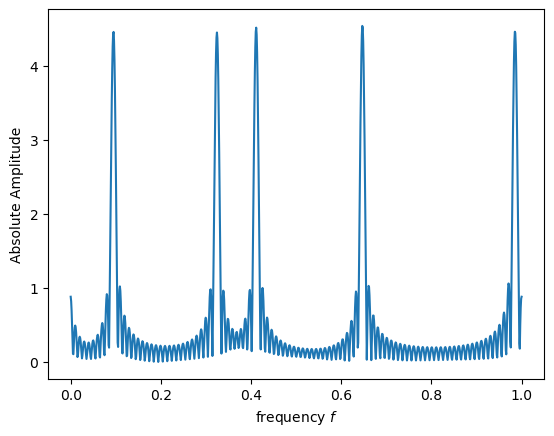

In [5]:
def ANM(x):
  c = cp.Constant(np.ones((1,1)))
  p = cp.Variable((M,1), complex=True)
  H = cp.Variable((M,M), complex=True)
  constraints = [ cp.bmat([
    [ H, p],
    [ p.H, c ]
  ]) >> 0 ]
  superDiagonal = lambda k : [ H[i,i+k] for i in range(M-k) ]
  delta = lambda k : 1 if (k == 0) else 1
  constraints += [ cp.sum(superDiagonal(k)) == delta(k) for k in range(M) ] 

  prob = cp.Problem(cp.Maximize( cp.real( cp.scalar_product(x,p) ) ), constraints)
  prob.solve()

  return p.value, H.value
  

def calcFreq(p,H,numSamples):
  graphX = np.linspace(0,1,numSamples)
  graphY = np.zeros((numSamples))
  for i in range(len(graphX)):
    tau = graphX[i]
    P = hermitian(a(tau)) @ p
    graphY[i] = np.sqrt(np.real(P)**2 + np.imag(P)**2)
  return graphX, graphY

print(X)
p, H = ANM(X[:,0].reshape(M,1))
graphX, graphY = calcFreq(p,H,1000)
draw(graphX, graphY, "frequency $f$", "Absolute Amplitude", "")

In [6]:
peaks, props = signal.find_peaks(graphY)
print(f)
print(np.sort(graphX[peaks[findNMaxPeaks(y,peaks,len(f))]]))
print(RMSE(graphX[np.sort(peaks[findNMaxPeaks(y,peaks,len(f))])],f))


[0.09465385461667863, 0.32432490481862997, 0.4112567321612291, 0.6468964488883266, 0.9855776390274656]
[0.0950951  0.32432432 0.41141141 0.64664665 0.98498498]
0.0003556006583854461


In [7]:
def test_speed(numSamples, numArrayElem, numFreqs=None, freqs=None):
  X = create_signal(100, numSample=numSamples, numArrElem=numArrayElem, numFreq=numFreqs) if type(freqs) == type(None) else create_signal(1, numSample=numSamples, numArrElem=numArrayElem, freqs=freqs)
  t0 = time.time()
  MUSIC(X, len(freqs) if type(numFreqs) == type(None) else numFreqs, 1000)
  t1 = time.time()
  print("MUSIC: {}s".format(t1-t0))
  t2 = time.time()
  p, H = ANM(X[:,0].reshape(M,1))
  calcFreq(p,H, 1000)
  t3 = time.time()
  print("ANM: {}s".format(t3-t2))
  return t1-t0, t3-t2
  

-50.0 [0.2, 0.5, 0.8] [0.82482482 0.3003003  0.02602603] [0.82482482 0.3003003  0.02602603] 0.15358296955069645 0.15358296955069645
-49.74937343358396 [0.2, 0.5, 0.8] [0.30830831 0.15715716 0.73273273] [0.30830831 0.15715716 0.73273273] 0.11986951112506339 0.11986951112506339
-49.49874686716792 [0.2, 0.5, 0.8] [0.25125125 0.63663664 0.9049049 ] [0.25125125 0.63663664 0.9049049 ] 0.10376463800238545 0.10376463800238545
-49.24812030075188 [0.2, 0.5, 0.8] [0.23423423 0.04504505 0.57157157] [0.23423423 0.04504505 0.57157157] 0.2212253957938507 0.2212253957938507
-48.99749373433584 [0.2, 0.5, 0.8] [0.97097097 0.51151151 0.21421421] [0.97097097 0.51151151 0.21421421] 0.09927341318762678 0.09927341318762678
-48.7468671679198 [0.2, 0.5, 0.8] [0.83683684 0.62562563 0.31531532] [0.83683684 0.62562563 0.31531532] 0.10072466150889459 0.10072466150889459
-48.49624060150376 [0.2, 0.5, 0.8] [0.03003003 0.33633634 0.46946947] [0.03003003 0.33633634 0.46946947] 0.23446820474440971 0.23446820474440971
-

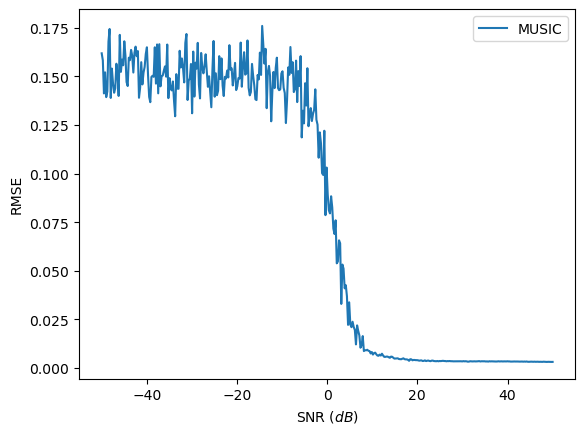

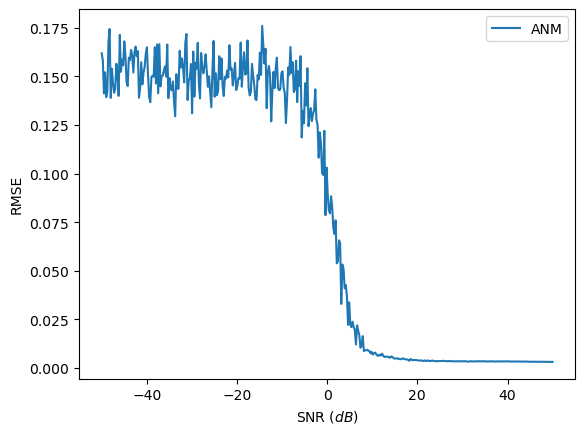

In [8]:
def test_error(k):
  X = create_signal(k,1,10,None,[0.2,0.5,0.8])
  freq = f
  yMusic = MUSIC(X, 1, 1000)
  p,H = ANM(X[:,0].reshape(M,1))
  graphX, graphY_ANM = calcFreq(p,H,1000)
  peaks_MUSIC, props = signal.find_peaks(yMusic)
  peaks_ANM, props = signal.find_peaks(graphY_ANM)
  peaks_MUSIC = peaks_MUSIC[findNMaxPeaks(yMusic, peaks_MUSIC, 3)]
  peaks_ANM = peaks_ANM[findNMaxPeaks(graphY_ANM, peaks_ANM, 3)]
  rmse1 = RMSE(np.sort(graphX[peaks_MUSIC]),freq)
  rmse2 = RMSE(np.sort(graphX[peaks_ANM]),freq)
  print(k, freq, graphX[peaks_MUSIC], graphX[peaks_ANM], rmse1, rmse2)
  return rmse1, rmse2

iterList = np.linspace(-50,50,400)
all_test_MUSIC = np.zeros((400))
all_test_ANM = np.zeros((400))
for iter in range(50):
  rmse_MUSIC = []
  rmse_ANM = []
  for k in iterList:
    rmse1, rmse2 = test_error(k)
    rmse_MUSIC.append(rmse1)
    rmse_ANM.append(rmse2)
  all_test_MUSIC += np.array(rmse_MUSIC)
  all_test_ANM += np.array(rmse_ANM)
all_test_MUSIC /= 50
all_test_ANM /= 50
plt.xlabel("SNR ($dB$)")
plt.ylabel("RMSE")
plt.plot(iterList, all_test_MUSIC, label = "MUSIC")
plt.legend()
plt.show()
plt.xlabel("SNR ($dB$)")
plt.ylabel("RMSE")
plt.plot(iterList, all_test_ANM, label = "ANM")
plt.legend()
plt.show()

[0.3, 0.31] [0.16116116 0.30530531] [0.16116116 0.30530531]
0.09822999370964414 0.09822999370964414 0 0
[0.3, 0.3101803607214429] [0.16116116 0.30530531] [0.16116116 0.30530531]
0.09823438638131628 0.09823438638131628 0 0
[0.3, 0.31036072144288573] [0.16116116 0.30530531] [0.16116116 0.30530531]
0.09823894442236533 0.09823894442236533 0 0
[0.3, 0.31054108216432863] [0.16116116 0.30530531] [0.16116116 0.30530531]
0.09824366780977424 0.09824366780977424 0 0
[0.3, 0.3107214428857715] [0.30530531 0.44944945] [0.30530531 0.44944945]
0.09816721975668445 0.09816721975668445 0 0
[0.3, 0.3109018036072144] [0.30530531 0.44944945] [0.30530531 0.44944945]
0.09803977874518047 0.09803977874518047 0 0
[0.3, 0.3110821643286573] [0.30530531 0.44944945] [0.30530531 0.44944945]
0.0979123379765826 0.0979123379765826 0 0
[0.3, 0.3112625250501002] [0.30530531 0.44944945] [0.30530531 0.44944945]
0.09778489745184057 0.09778489745184057 0 0
[0.3, 0.31144288577154305] [0.30530531 0.44944945] [0.30530531 0.44944

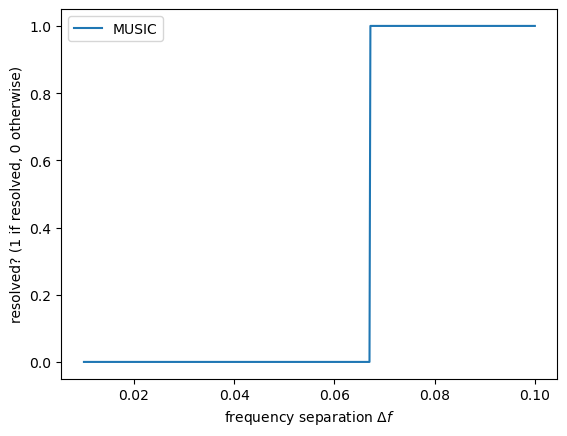

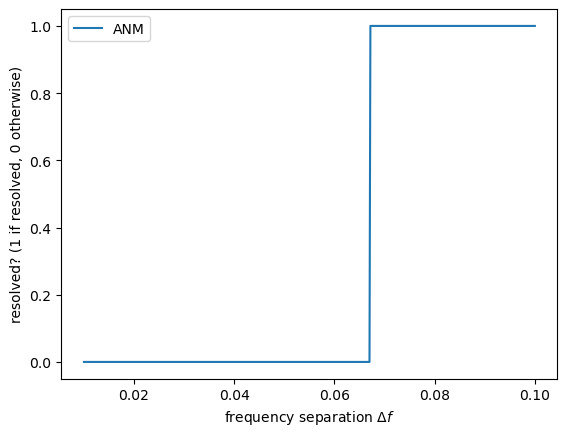

In [9]:
def test_superResolution(separation):
  X = create_signal(100,1,10,None,[0.3, 0.3+separation])
  freq = f
  yMusic = MUSIC(X, 1, 1000)
  p,H = ANM(X[:,0].reshape(M,1))
  graphX, graphY_ANM = calcFreq(p,H,1000)

  peaks_MUSIC, props = signal.find_peaks(yMusic)
  peaks_ANM, props = signal.find_peaks(graphY_ANM)
  peaks_MUSIC = peaks_MUSIC[findNMaxPeaks(yMusic, peaks_MUSIC, 2)]
  peaks_ANM = peaks_ANM[findNMaxPeaks(graphY_ANM, peaks_ANM, 2)]
  print(freq, np.sort(graphX[peaks_MUSIC]), np.sort(graphX[peaks_ANM]))
  # draw(graphX, yMusic, "", "", "")
  # draw(graphX, graphY_ANM, "", "", "")
  ret_MUSIC = 1 if RMSE(np.sort(graphX[peaks_MUSIC]), freq) < 0.03 else 0
  ret_ANM = 1 if RMSE(np.sort(graphX[peaks_ANM]), freq) < 0.03 else 0
  print(RMSE(np.sort(graphX[peaks_MUSIC]), freq),RMSE(np.sort(graphX[peaks_ANM]), freq), ret_MUSIC, ret_ANM)
  return ret_MUSIC, ret_ANM

# test_superResolution(0.01)
boolMUSIC = []
boolANM = []
iterList = np.linspace(0.01,0.1,500)
for separation in iterList:
  bool1, bool2 = test_superResolution(separation)
  boolMUSIC.append(bool1)
  boolANM.append(bool2)
plt.xlabel("frequency separation $\Delta f$")
plt.ylabel("resolved? (1 if resolved, 0 otherwise)")
plt.plot(iterList, boolMUSIC, label = "MUSIC")
plt.legend()
plt.show()
plt.xlabel("frequency separation $\Delta f$")
plt.ylabel("resolved? (1 if resolved, 0 otherwise)")
plt.plot(iterList, boolANM, label = "ANM")
plt.legend()
plt.show()

In [10]:
bothResolved = False
oneResolved = False
for i in range(500):
  x = iterList[i]
  bool1 = boolMUSIC[i]
  bool2 = boolANM[i]
  if (bothResolved and oneResolved):
    break
  if (bool1 == 0 and bool2 == 0):
    continue
  elif (bool1 == 1 and bool2 == 1):
    if (not bothResolved):
      print('both resolved at x= ',x)
      bothResolved = True
  else:
    if (not oneResolved):
      print('{} resolved at x= {}'.format('MUSIC' if bool1 == 1 else 'ANM', x))
      oneResolved = True

both resolved at x=  0.06717434869739479


MUSIC: 0.014949321746826172s
ANM: 0.07775378227233887s
MUSIC: 0.013953685760498047s
ANM: 0.0842275619506836s
MUSIC: 0.014949798583984375s
ANM: 0.10507917404174805s
MUSIC: 0.01594686508178711s
ANM: 0.14950227737426758s
MUSIC: 0.0174710750579834s
ANM: 0.23642539978027344s
MUSIC: 0.019440650939941406s
ANM: 0.24322724342346191s
MUSIC: 0.021608829498291016s
ANM: 0.2586662769317627s
MUSIC: 0.0222017765045166s
ANM: 0.3721146583557129s
MUSIC: 0.023429393768310547s
ANM: 0.43503332138061523s
MUSIC: 0.025949478149414062s
ANM: 0.5400569438934326s
MUSIC: 0.026910066604614258s
ANM: 0.5665292739868164s
MUSIC: 0.02790689468383789s
ANM: 0.5760955810546875s
MUSIC: 0.02989983558654785s
ANM: 0.7022888660430908s
MUSIC: 0.030896663665771484s
ANM: 0.8344056606292725s
MUSIC: 0.031893253326416016s
ANM: 0.8670327663421631s
MUSIC: 0.03388667106628418s
ANM: 0.9526114463806152s
MUSIC: 0.03488492965698242s
ANM: 1.029198169708252s
MUSIC: 0.03687763214111328s
ANM: 1.1675238609313965s
MUSIC: 0.03838324546813965s
ANM: 

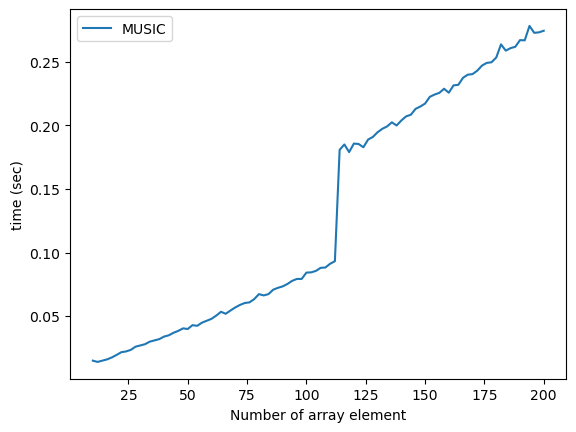

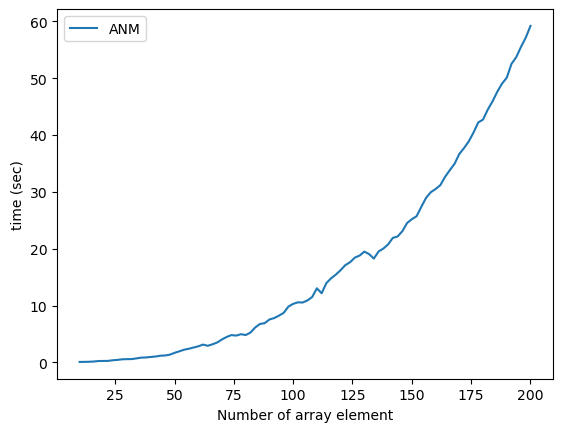

In [11]:
T1 = []
T2 = []
x = []
for k in range(96):
  x.append(10+2*k)
  t1, t2 = test_speed(1, 10+2*k, 5)
  T1.append(t1)
  T2.append(t2)
plt.xlabel("Number of array element")
plt.ylabel("time (sec)")
plt.plot(x, T1, label = "MUSIC")
plt.legend()
plt.show()
plt.xlabel("Number of array element")
plt.ylabel("time (sec)")
plt.plot(x, T2, label = "ANM")
plt.legend()
plt.show()

MUSIC: 0.08600974082946777s
ANM: 10.16322922706604s
MUSIC: 0.08622312545776367s
ANM: 9.55188274383545s
MUSIC: 0.08255505561828613s
ANM: 8.57047724723816s
MUSIC: 0.08268880844116211s
ANM: 8.429078817367554s
MUSIC: 0.08249068260192871s
ANM: 11.105825424194336s
MUSIC: 0.08338284492492676s
ANM: 11.033516645431519s
MUSIC: 0.08272480964660645s
ANM: 11.816665649414062s
MUSIC: 0.08272862434387207s
ANM: 12.6054208278656s
MUSIC: 0.08223104476928711s
ANM: 13.47421145439148s
MUSIC: 0.08623266220092773s
ANM: 12.621331453323364s


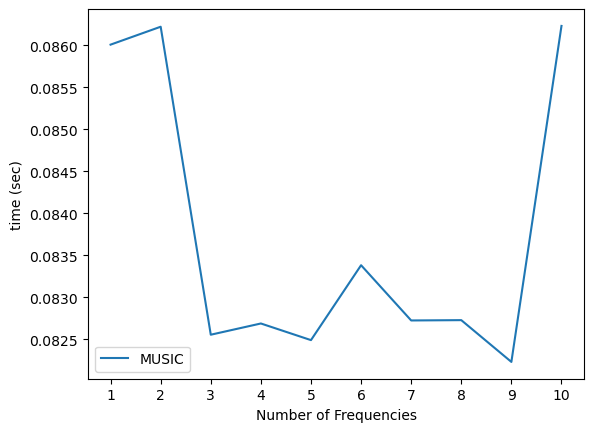

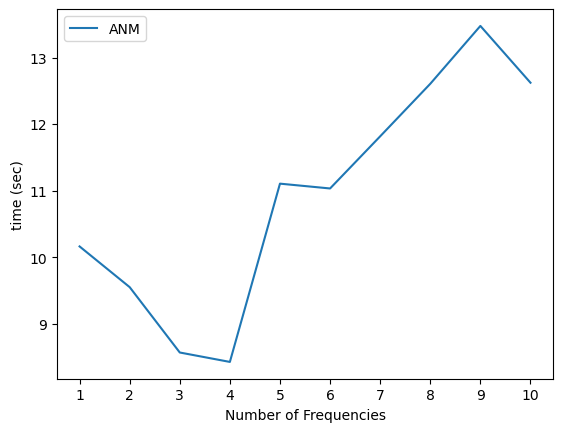

In [12]:
T1 = []
T2 = []
x = []
for k in range(10):
  numFreq = k+1
  x.append(numFreq)
  f = np.linspace(0,1-epsilon, numFreq)
  t1, t2 = test_speed(1, 100, freqs=f)
  T1.append(t1)
  T2.append(t2)
plt.xlabel("Number of Frequencies")
plt.xticks(x)
plt.ylabel("time (sec)")
plt.plot(x, T1, label = "MUSIC")
plt.legend()
plt.show()
plt.xlabel("Number of Frequencies")
plt.xticks(x)
plt.ylabel("time (sec)")
plt.plot(x, T2, label = "ANM")
plt.legend()
plt.show()